# Hyperparameter tuning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.metrics import make_scorer

In [2]:
data = pd.read_csv('../../datasets/data-stemmed-R.csv')
Y = data['engagement.rate']
X = data.drop(columns=['engagement.rate'])
columns_to_scale= ['quotes','user.tweets','user.following','user.media'] 
scaler = StandardScaler()
X[columns_to_scale]= scaler.fit_transform(X[columns_to_scale]) 

In [3]:
def rmse_scorer(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return -rmse  # Negate the result for GridSearchCV

**DISCLAIMER:** we want a robust result about the optimal hyperparameters, so we are going to implement a CV. 
Since our future models will be trained in training sets with size $\frac{9}{10}|D|$, we can do hyperparameter tuning with CV on the entire dataset (in order to mantain the same proportion)

# Decision tree

In [4]:
param_grid = {'min_samples_split': [2, 11, 16, 26,31, 51, 101, 151, 201,501]}
# Create RegressorTree
dt = DecisionTreeRegressor()

# Use GridSearchCV to find the best hyperparameters
dt_grid_search = GridSearchCV(dt, param_grid, cv=10, scoring=make_scorer(rmse_scorer))
dt_grid_search.fit(X, Y)

# Print the best hyperparameters
dt_best_params = dt_grid_search.best_params_

In [5]:
print(f"Decision trees Best hyperparameters: {dt_best_params}")

Decision trees Best hyperparameters: {'min_samples_split': 101}


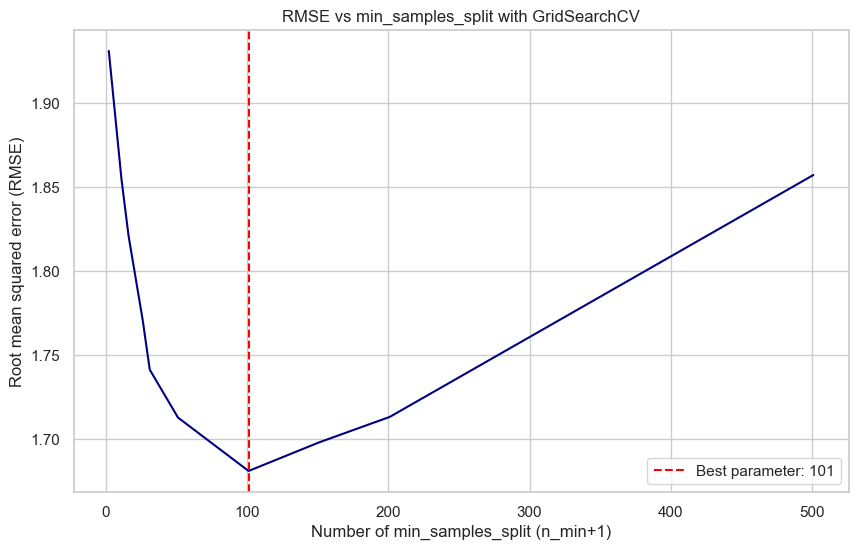

In [58]:
# Get the results in a DataFrame
dt_results = pd.DataFrame(dt_grid_search.cv_results_)

# Plot MAE vs n_neighbors using Seaborn
fig=plt.figure(figsize=(10, 6))
sns.lineplot(x=dt_results['param_min_samples_split'], y=-dt_results['mean_test_score'],color='navy')

# Highlight the best parameter
dt_best_param = dt_grid_search.best_params_['min_samples_split']
plt.axvline(x=dt_best_param, color='red', linestyle='--', label=f'Best parameter: {dt_best_param}')

# Add labels and title
plt.xlabel('Number of min_samples_split (n_min+1)')
plt.ylabel('Root mean squared error (RMSE)')
plt.title('RMSE vs min_samples_split with GridSearchCV')
plt.legend(loc='lower right')

# Show the plot
plt.show()
# Save the plot as png
fig.savefig('../../plots/dt_grid_search.png')

# Knn

In [11]:
# Define the range of neighbors
param_grid = {'n_neighbors': [1, 2, 5, 10, 15, 20, 50, 100]}

# Create KNeighborsRegressor
knn = KNeighborsRegressor()

# Use GridSearchCV to find the best hyperparameters
knn_grid_search = GridSearchCV(knn, param_grid, cv=10, scoring=make_scorer(rmse_scorer))
knn_grid_search.fit(X, Y)

# Print the best hyperparameters
knn_best_params = knn_grid_search.best_params_

In [12]:
print(f"KNN Best hyperparameters: {knn_best_params}")

KNN Best hyperparameters: {'n_neighbors': 20}


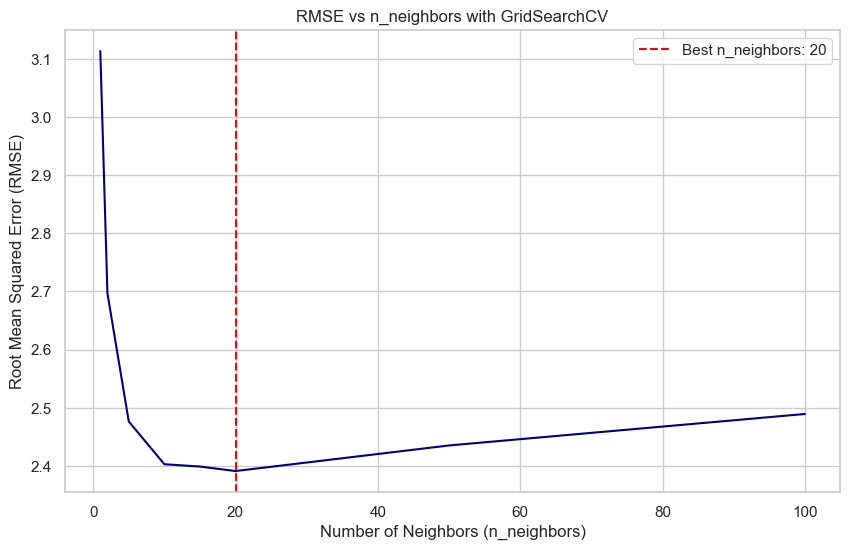

In [59]:
# Get the results in a DataFrame
knn_results = pd.DataFrame(knn_grid_search.cv_results_)

# Plot MAE vs n_neighbors using Seaborn
fig=plt.figure(figsize=(10, 6))
sns.lineplot(x=knn_results['param_n_neighbors'], y=-knn_results['mean_test_score'],color='navy')

# Highlight the best parameter
knn_best_param = knn_grid_search.best_params_['n_neighbors']
plt.axvline(x=knn_best_param, color='red', linestyle='--', label=f'Best n_neighbors: {knn_best_param}')

# Add labels and title
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE vs n_neighbors with GridSearchCV')
plt.legend()

# Show the plot
plt.show()
# Save the plot as png
fig.savefig('../../plots/knn_grid_search.png')

# Random Forest

In [14]:
n_estimators= [10,15,25,50,75,100, 250, 500]
min_samples_split= [2, 11, 26, 51,76,101] #corrisponde a 1+n_min di medvet
max_features= [math.floor(math.sqrt(X.shape[1])), X.shape[1] // 3]

param_grid = {
    'n_estimators': n_estimators,
    'min_samples_split': min_samples_split,
    'max_features': max_features
}

# Create KNeighborsRegressor
rf = RandomForestRegressor(n_jobs=-1) #n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.

# Use GridSearchCV to find the best hyperparameters
rf_grid_search = GridSearchCV(rf, param_grid, cv=10, scoring=make_scorer(rmse_scorer))
rf_grid_search.fit(X, Y)

# Print the best hyperparameters
rf_best_params = rf_grid_search.best_params_

In [15]:
print(f"Random forest Best hyperparameters: {rf_best_params}")

Random forest Best hyperparameters: {'max_features': 94, 'min_samples_split': 2, 'n_estimators': 500}


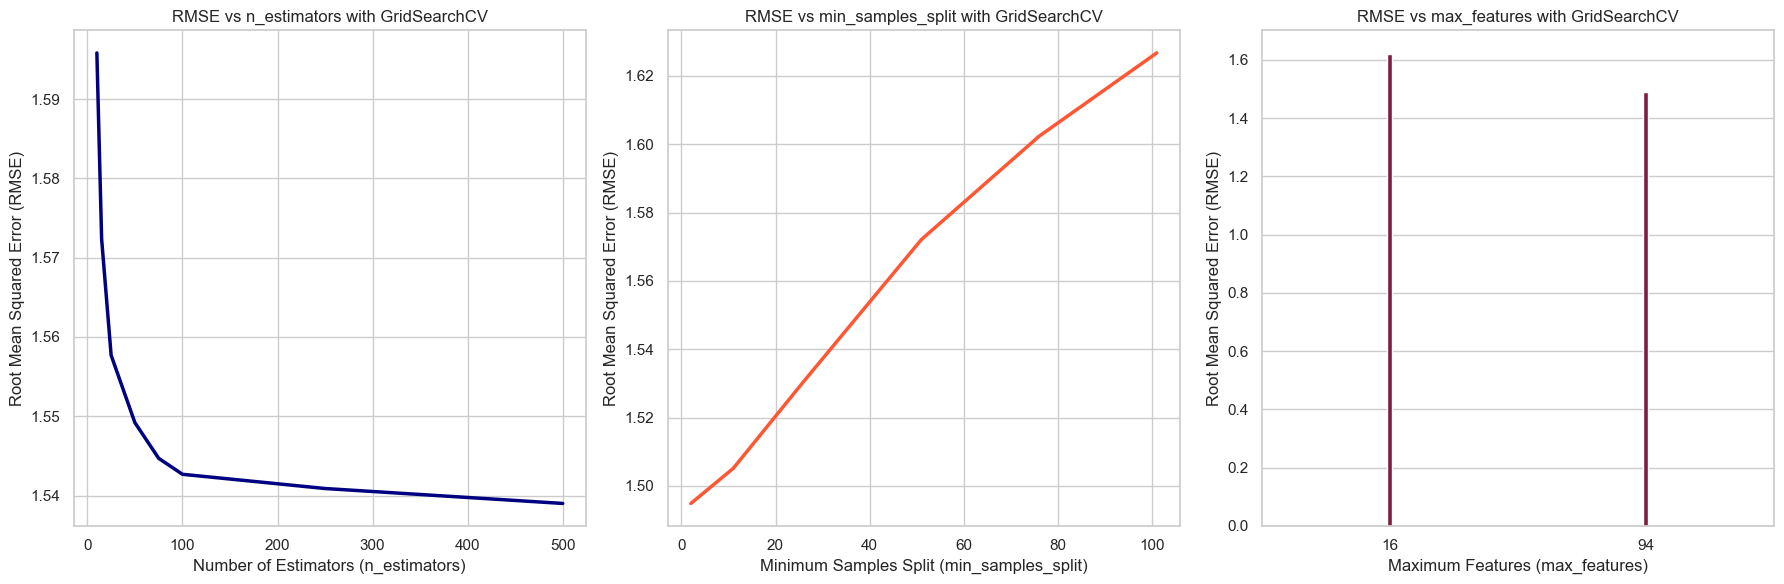

In [61]:
# Get the results in a DataFrame
rf_results = pd.DataFrame(rf_grid_search.cv_results_)

# Create a 1x3 matrix of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot MAE vs n_estimators
sns.lineplot(x='param_n_estimators', y=-rf_results['mean_test_score'],
             data=rf_results, ax=axes[0],errorbar=None,linewidth = 2.5,
             color='navy')
axes[0].set_xlabel('Number of Estimators (n_estimators)')
axes[0].set_ylabel('Root Mean Squared Error (RMSE)')
axes[0].set_title('RMSE vs n_estimators with GridSearchCV')

# Plot MAE vs min_samples_split
sns.lineplot(x='param_min_samples_split', y=-rf_results['mean_test_score'],
             data=rf_results, ax=axes[1],errorbar=None,linewidth = 2.5,
             color='#FF5733')
axes[1].set_xlabel('Minimum Samples Split (min_samples_split)')
axes[1].set_ylabel('Root Mean Squared Error (RMSE)')
axes[1].set_title('RMSE vs min_samples_split with GridSearchCV')

# Plot MAE vs max_features
sns.barplot(x='param_max_features', y=-rf_results['mean_test_score'],
             data=rf_results, ax=axes[2],errorbar=None,
             color='#900C3F',width=0.02)
axes[2].set_xlabel('Maximum Features (max_features)')
axes[2].set_ylabel('Root Mean Squared Error (RMSE)')
axes[2].set_title('RMSE vs max_features with GridSearchCV')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()
# Save the plot as png
fig.savefig('../../plots/rf_grid_search.png')

In [22]:
# Extracting necessary columns
desired_columns = ['param_n_estimators', 'param_min_samples_split', 'param_max_features', 'mean_test_score']
extracted_data = rf_results[desired_columns].copy()

# Renaming columns for clarity
extracted_data.columns = ['n_estimators', 'min_samples_split', 'max_features', 'rmse']

# Converting negative mean test scores to positive MAE
extracted_data['rmse'] = -extracted_data['rmse']

extracted_data=extracted_data[extracted_data['max_features']==X.shape[1] // 3]

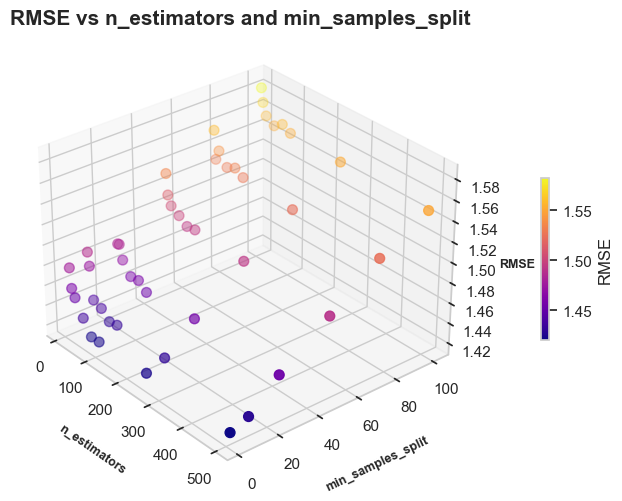

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Assuming extracted_data is your DataFrame
sns.set(style="whitegrid")
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(extracted_data['n_estimators'], extracted_data['min_samples_split'], extracted_data['rmse'],
                     c=extracted_data['rmse'], cmap='plasma', s=50)

# Customize the plot
ax.set_xlabel('n_estimators', labelpad=10, fontsize=9, fontweight='bold')
ax.set_ylabel('min_samples_split', labelpad=10, fontsize=9, fontweight='bold')
ax.set_zlabel('RMSE', labelpad=5, fontsize=9, fontweight='bold')
ax.set_title('RMSE vs n_estimators and min_samples_split',
             fontsize=15, fontweight='bold')

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax, label='RMSE', shrink=0.3, pad=.12)

# Change the perspective
ax.view_init(elev=30, azim=-40)  # Adjust the elevation and azimuthal angle as needed

# Show the plot
plt.show()
#save as image
fig.savefig('../../plots/rmse_vs_n_estimators_and_min_samples_split_POINTS.png')



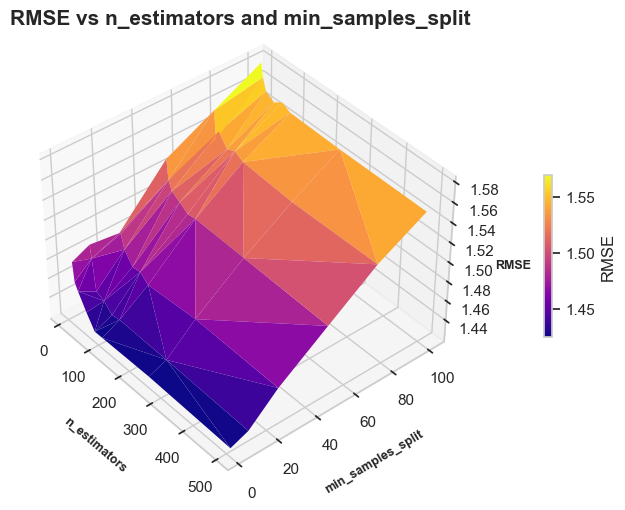

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import seaborn as sns

# Assuming extracted_data is your DataFrame
sns.set(style="whitegrid")
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a continuous surface
surf = ax.plot_trisurf(extracted_data['n_estimators'], extracted_data['min_samples_split'],
                       extracted_data['rmse'], cmap='plasma', linewidth=0, antialiased=True)

# Customize the plot
ax.set_xlabel('n_estimators', labelpad=10, fontsize=9, fontweight='bold')
ax.set_ylabel('min_samples_split', labelpad=10, fontsize=9, fontweight='bold')
ax.set_zlabel('RMSE', labelpad=5, fontsize=9, fontweight='bold')
ax.set_title('RMSE vs n_estimators and min_samples_split',
             fontsize=15, fontweight='bold')

# Add a colorbar
cbar = plt.colorbar(surf, ax=ax, label='RMSE', shrink=0.3, pad=.13)
ax.view_init(elev=40, azim=-40) 
# Show the plot
plt.show()
#save as image
fig.savefig('../../plots/rmse_vs_n_estimators_and_min_samples_split_SURFACE.png')


# SVR

NB: instead of using the custom RMSE, we use neg_mean_squared_error as scoring ad later we'll compute its sqrt

**Without scaling vars, svr is an asshole!**

In [45]:
param_grid = {'kernel': ['linear', 'poly', 'rbf']}

sv = SVR()

# Use GridSearchCV to find the best hyperparameters
sv_grid_search = GridSearchCV(sv, param_grid, cv=10, scoring='neg_mean_squared_error')
sv_grid_search.fit(X, Y)

# Print the best hyperparameters
sv_best_params = sv_grid_search.best_params_

In [46]:
print(f"SVR best kernel: {sv_best_params}")

SVR best kernel: {'kernel': 'rbf'}


In [71]:
sv_results = pd.DataFrame(sv_grid_search.cv_results_)

In [72]:
sv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,17.815603,1.916914,0.155446,0.001292,linear,{'kernel': 'linear'},-4.633037,-5.033080,-5.358729,-5.164891,-5.861049,-5.216260,-4.415371,-4.512649,-5.711287,-6.060979,-5.196733,0.538857,2
1,1.555863,0.033758,0.158933,0.001558,poly,{'kernel': 'poly'},-11.649646,-5.894345,-7.040328,-62.468044,-6.514096,-6.043970,-315.617632,-4.860067,-6.023409,-6.828381,-43.293992,92.292234,3
2,1.575919,0.011624,0.276013,0.002646,rbf,{'kernel': 'rbf'},-4.030989,-4.802948,-4.939416,-4.692454,-5.944205,-5.098685,-4.009053,-4.322524,-5.033452,-5.942137,-4.881586,0.645508,1


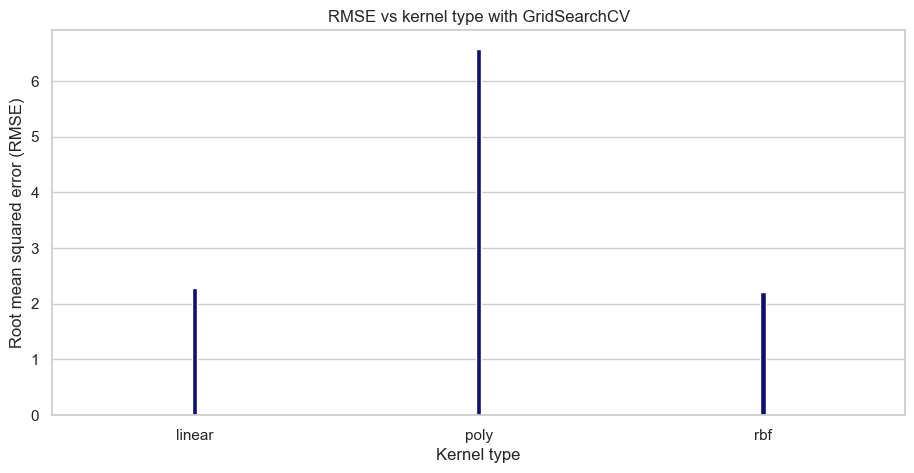

In [89]:
# Get the results in a DataFrame
sv_results = pd.DataFrame(sv_grid_search.cv_results_)

# Plot MAE vs n_neighbors using Seaborn
fig=plt.figure(figsize=(11,5))
sns.barplot(x=sv_results['param_kernel'], y=np.sqrt(-sv_results['mean_test_score']),color='navy',
          errorbar=None,width=0.02)
# # Add labels and title
plt.xlabel('Kernel type')
plt.ylabel('Root mean squared error (RMSE)')
plt.title('RMSE vs kernel type with GridSearchCV')
# Show the plot
plt.show()
# Save figure as png
fig.savefig('../../plots/svr_grid_search.png')